#**Project: Predicting Ratings of Google Play Store Apps**

##**Introduction**

Android maintained its position as the leading mobile operating system worldwide in June 2021, controlling the mobile OS market with a close to 73 percent share. The Google Play Store is the main Android app store. [From statista](https://www.statista.com/statistics/272698/global-market-share-held-by-mobile-operating-systems-since-2009/#:~:text=Android%20maintained%20its%20position%20as,of%20the%20global%20market%20share). 

##**Objective**

The goal of our project is to analyze the features of apps on the Google Play Store, understanding the current market, and uncovering the following questions in order to provide insight for app-making business and develop marketing strategies to drive sales.

 - What is the most popular category?
 - Which apps were downloaded the most?
 - Does rating influence the app installations?
 - What are the ratings of Free vs Paid apps?

##**Literature**

Some of the projects using the same topic focus on predicting the popularity of the apps on the Google Play Store such as the project, *Analysis of Google Play Store Dataset and Predicting the popularity of an app on Google Play Store*, conducted by *Rimsha Maredia*, *Texas A&M University*. This team found that variable Installs has the strongest correlation with the variable Reviews, and they argued that it is reasonable a popular app tends to have more Reviews and thus more Installs. Hence, they use Installs to predict whether an app is successful/popular or unsuccessful/unpopular.

Unlike their binary target variable, our target variable is a continuous one. We found some variables have correlations with our target variable, Rating and thus we used Installs, Price, Size, and Reviews as our predictors to predict the rating of the app, and get a predicted Rating between 1 and 5.

In [1]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Import Libraries

In [2]:
# import package
import pandas as pd              # For data analysis
import numpy as np               
import seaborn as sns            # Visualization package
import matplotlib.pyplot as plt

import statsmodels.api as sm  
from sklearn.preprocessing import StandardScaler     # To standardize features
from sklearn.model_selection import train_test_split # To split data into train and test subsets
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor  # To create models
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn import metrics        # To access models
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report,confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#2. Pre-processing Data

## Data Exploration
The dataset comes from [Kaggle](https://www.kaggle.com/itsbitan/google-play-store-app-rating-prediction/data). It contains the list, price, reviews, ratings, etc. of the Android Apps. The shape of the size is 10842 rows and 13 columns. The target variable for this project is Ratings, and the predictors include Reviews, Size, Installs, and Price.

In [4]:
# Read dataset
df = pd.read_csv('/content/drive/MyDrive/Project Dataset/Predicting Ratings of Apps/googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [5]:
# Chenk dataset details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [6]:
# Explore numeric variable
'''The rating should range between 1.0 to 5.0, so there are outliners'''

df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


When using info() and describe() function, we found most of the features on the dataset were considered objects. To understand other features too, we further used describe(include=['O']) to check them. This action gave us some clues about what variables we want to transform and how to transform them.

In [7]:
# Explore categorical variable
df.describe(include=['O'])

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841,10841,10841,10841,10841,10840,10841,10840,10841,10841,10833,10838
unique,9660,34,6002,462,22,3,93,6,120,1378,2784,33
top,ROBLOX,FAMILY,0,Varies with device,"1,000,000+",Free,0,Everyone,Tools,3-Aug-18,Varies with device,4.1 and up
freq,9,1972,596,1695,1579,10039,10040,8714,842,326,1459,2451


Assumption / Action: 

- Installs, Reviews, Size, Price: Will change them to numeric variables so that I can aggregate them per each App category.
- Last updated of the App, Current Version of the Apps, and Android version of the phone system will not impact the popularity of the Apps, and thus I won't use them for my prediction.


In [8]:
# Check the type of our dataset because we wanted to make sure it's the proper type so that we can do futher analysis.
print(type(df))
df.shape

<class 'pandas.core.frame.DataFrame'>


(10841, 13)

In [9]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [10]:
# Closer look at the missing values for Rating
df[df['Rating'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
23,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61,7.0M,"100,000+",Free,0,Everyone,Art & Design;Action & Adventure,7-Mar-18,1.0.0,4.1 and up
113,Wrinkles and rejuvenation,BEAUTY,NaN,182,5.7M,"100,000+",Free,0,Everyone 10+,Beauty,20-Sep-17,8,3.0 and up
123,Manicure - nail design,BEAUTY,NaN,119,3.7M,"50,000+",Free,0,Everyone,Beauty,23-Jul-18,1.3,4.1 and up
126,Skin Care and Natural Beauty,BEAUTY,NaN,654,7.4M,"100,000+",Free,0,Teen,Beauty,17-Jul-18,1.15,4.1 and up
129,"Secrets of beauty, youth and health",BEAUTY,NaN,77,2.9M,"10,000+",Free,0,Mature 17+,Beauty,8-Aug-17,2,2.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10824,Cardio-FR,MEDICAL,NaN,67,82M,"10,000+",Free,0,Everyone,Medical,31-Jul-18,2.2.2,4.4 and up
10825,Naruto & Boruto FR,SOCIAL,NaN,7,7.7M,100+,Free,0,Teen,Social,2-Feb-18,1,4.0 and up
10831,payermonstationnement.fr,MAPS_AND_NAVIGATION,NaN,38,9.8M,"5,000+",Free,0,Everyone,Maps & Navigation,13-Jun-18,2.0.148.0,4.0 and up
10835,FR Forms,BUSINESS,NaN,0,9.6M,10+,Free,0,Everyone,Business,29-Sep-16,1.1.5,4.0 and up


Rating is our target variable and the null values account 13% of the rows, we decided to impute them with mean value because dropping them is not feasible, and imputing with 0 may skew the dataset. Imputing null with the mean values wouldn't.

AxesSubplot(0.125,0.125;0.775x0.755)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,11-Feb-18,1.0.19,4.0 and up,NaN


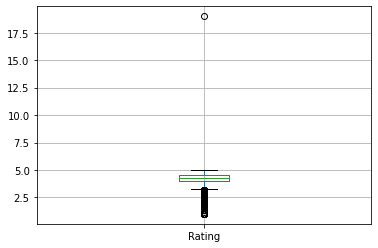

In [11]:
 # Check for distribution of the Rating and to spot outliers by looking at the boxplot
print(df.boxplot())
df[df['Rating'] > 5]

There is one Rating that was obviously an outlier and since there was only one data point, we will later drop it.

In [12]:
# Wants to find out what Price looks like when it is not free so that we can clean it to make it numeric
df[df['Price'] != '0']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
234,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6.8M,"100,000+",Paid,$4.99,Everyone,Business,25-Mar-18,1.5.2,4.0 and up
235,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39M,"100,000+",Paid,$4.99,Everyone,Business,11-Apr-17,3.4.6,3.0 and up
290,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6.8M,"100,000+",Paid,$4.99,Everyone,Business,25-Mar-18,1.5.2,4.0 and up
291,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39M,"100,000+",Paid,$4.99,Everyone,Business,11-Apr-17,3.4.6,3.0 and up
427,Puffin Browser Pro,COMMUNICATION,4.0,18247,Varies with device,"100,000+",Paid,$3.99,Everyone,Communication,5-Jul-18,7.5.3.20547,4.1 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,FP VoiceBot,FAMILY,NaN,17,157k,100+,Paid,$0.99,Mature 17+,Entertainment,25-Nov-15,1.2,2.1 and up
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,2.4M,"1,000+",Paid,$7.99,Everyone,Health & Fitness,8-Aug-18,1.9.3,4.2 and up
10782,Trine 2: Complete Story,GAME,3.8,252,11M,"10,000+",Paid,$16.99,Teen,Action,27-Feb-15,2.22,5.0 and up
10785,"sugar, sugar",FAMILY,4.2,1405,9.5M,"10,000+",Paid,$1.20,Everyone,Puzzle,5-Jun-18,2.7,2.3 and up


Need to address the "$' in front of Price.



## Data Cleaning

In [13]:
# First to work on the target variable, Rating
# Drop the only outliner since 5 is the highest possible rating and dropping one row should not affect the prediction.
df.drop([10472], inplace=True)

# Check that the record has been dropped
df[10470:10475]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10470,Jazz Wi-Fi,COMMUNICATION,3.4,49,4.0M,"10,000+",Free,0,Everyone,Communication,10-Feb-17,0.1,2.3 and up
10471,Xposed Wi-Fi-Pwd,PERSONALIZATION,3.5,1042,404k,"100,000+",Free,0,Everyone,Personalization,5-Aug-14,3.0.0,4.0.3 and up
10473,osmino Wi-Fi: free WiFi,TOOLS,4.2,134203,4.1M,"10,000,000+",Free,0,Everyone,Tools,7-Aug-18,6.06.14,4.4 and up
10474,Sat-Fi Voice,COMMUNICATION,3.4,37,14M,"1,000+",Free,0,Everyone,Communication,21-Nov-14,2.2.1.5,2.2 and up
10475,Wi-Fi Visualizer,TOOLS,3.9,132,2.6M,"50,000+",Free,0,Everyone,Tools,17-May-17,0.0.9,2.3 and up


AxesSubplot(0.125,0.125;0.775x0.755)


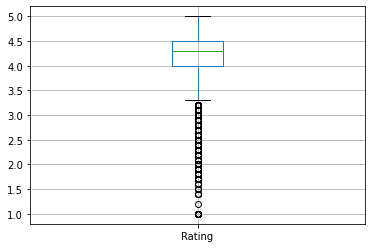

In [14]:
# Check the new distribution
print(df.boxplot())

In [15]:
# Impoute mean for null value
df['Rating'].fillna(round(df['Rating'].mean(),1), inplace=True)

# Check if any null value still exists
df.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

In [16]:
# Convert Price to numerical data
# Remove '$' and convert them to float if the value is not 0
# We made price as numerical variable because it is more close to the real world situation.

df['Price']=df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price']=df['Price'].apply(lambda x: float(x))

In [17]:
# Double check the type
print(df.info())

# Check how Price looks like now
df[df['Price'] != 0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  object 
 4   Size            10840 non-null  object 
 5   Installs        10840 non-null  object 
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  float64
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.2+ MB
None


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
234,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6.8M,"100,000+",Paid,4.99,Everyone,Business,25-Mar-18,1.5.2,4.0 and up
235,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39M,"100,000+",Paid,4.99,Everyone,Business,11-Apr-17,3.4.6,3.0 and up
290,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6.8M,"100,000+",Paid,4.99,Everyone,Business,25-Mar-18,1.5.2,4.0 and up
291,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39M,"100,000+",Paid,4.99,Everyone,Business,11-Apr-17,3.4.6,3.0 and up
427,Puffin Browser Pro,COMMUNICATION,4.0,18247,Varies with device,"100,000+",Paid,3.99,Everyone,Communication,5-Jul-18,7.5.3.20547,4.1 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,FP VoiceBot,FAMILY,4.2,17,157k,100+,Paid,0.99,Mature 17+,Entertainment,25-Nov-15,1.2,2.1 and up
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,2.4M,"1,000+",Paid,7.99,Everyone,Health & Fitness,8-Aug-18,1.9.3,4.2 and up
10782,Trine 2: Complete Story,GAME,3.8,252,11M,"10,000+",Paid,16.99,Teen,Action,27-Feb-15,2.22,5.0 and up
10785,"sugar, sugar",FAMILY,4.2,1405,9.5M,"10,000+",Paid,1.20,Everyone,Puzzle,5-Jun-18,2.7,2.3 and up


In [18]:
# Since Reviews means "number of user reviews", 
# and all the values are numbers, we believe it should be numerical data.

# Convert Reviews to integer
df['Reviews']=pd.to_numeric(df['Reviews'], errors='coerce')

# Check
df['Reviews'].head

<bound method NDFrame.head of 0           159
1           967
2         87510
3        215644
4           967
          ...  
10836        38
10837         4
10838         3
10839       114
10840    398307
Name: Reviews, Length: 10840, dtype: int64>

In [19]:
# Since Installs means "number of user installs the app", we believe it should be numerical data.
# Remove '+' and ',' and keep only numbers
df['Installs']=df['Installs'].apply(lambda x: str(x).replace('+', '') if '+' in str(x) else str(x))
df['Installs']=df['Installs'].apply(lambda x: str(x).replace(',', '') if ',' in str(x) else str(x))

# Convert Installs to integer
df['Installs']=pd.to_numeric(df['Installs'], errors='coerce')

# Check
df['Installs'].head()

0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: int64

In [20]:
# Curious to know what Sizes generally look like
df['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '79k', '8.4M', '118k', '44M', '695k', '1.6M',
     

In [21]:
# Size means "the size of the app", we believe it should be numerical data.
# Remove . and replace M with six 0 as well as k with three 0
df['Size']=df['Size'].apply(lambda x: str(x).replace('.', '') if '.' in str(x) else str(x))
df['Size']=df['Size'].str.replace('M','000000').str.replace('k','000')

In [22]:
# Check how many rows with the Size named 'Varies with device'
df[df['Size'] == 'Varies with device']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
37,Floor Plan Creator,ART_AND_DESIGN,4.1,36639,Varies with device,5000000,Free,0.0,Everyone,Art & Design,14-Jul-18,Varies with device,2.3.3 and up
42,Textgram - write on photos,ART_AND_DESIGN,4.4,295221,Varies with device,10000000,Free,0.0,Everyone,Art & Design,30-Jul-18,Varies with device,Varies with device
52,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,4.6,17057,Varies with device,1000000,Free,0.0,Everyone,Auto & Vehicles,30-Jul-18,Varies with device,Varies with device
67,Ulysse Speedometer,AUTO_AND_VEHICLES,4.3,40211,Varies with device,5000000,Free,0.0,Everyone,Auto & Vehicles,30-Jul-18,Varies with device,Varies with device
68,REPUVE,AUTO_AND_VEHICLES,3.9,356,Varies with device,100000,Free,0.0,Everyone,Auto & Vehicles,25-May-18,Varies with device,Varies with device
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10713,My Earthquake Alerts - US & Worldwide Earthquakes,WEATHER,4.4,3471,Varies with device,100000,Free,0.0,Everyone,Weather,24-Jul-18,Varies with device,Varies with device
10725,Posta App,MAPS_AND_NAVIGATION,3.6,8,Varies with device,1000,Free,0.0,Everyone,Maps & Navigation,27-Sep-17,Varies with device,4.4 and up
10765,Chat For Strangers - Video Chat,SOCIAL,3.4,622,Varies with device,100000,Free,0.0,Mature 17+,Social,23-May-18,Varies with device,Varies with device
10826,Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,Varies with device,5000000,Free,0.0,Mature 17+,Social,23-Mar-18,Varies with device,Varies with device


In [23]:
# Too many rows with 'Varies with device', we don't want to delete them and want to replace them with a general size value.
# To find the general Size value, we're going to explore mean and median for the rest of the Size:

# Create new DataFrame for only Size
df_size = pd.DataFrame(df['Size'])
df_size

# Only keep numeric values
df_size_re = df_size[df_size['Size'] != 'Varies with device']
df_size_re

,Size
0,19000000
1,14000000
2,87000000
3,25000000
4,28000000
...,...
10835,96000000
10836,53000000
10837,36000000
10838,95000000


In [24]:
# Transform those values to numeric
df_size_re['Size']=pd.to_numeric(df_size_re['Size'], errors='coerce')
df_size_re.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9145 entries, 0 to 10840
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Size    9145 non-null   int64
dtypes: int64(1)
memory usage: 142.9 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


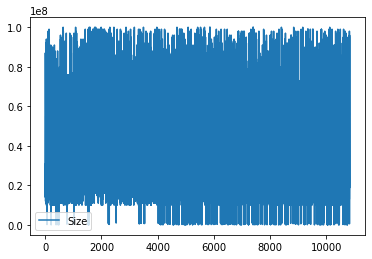

In [25]:
# Check its distribution
df_size_re.plot()
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


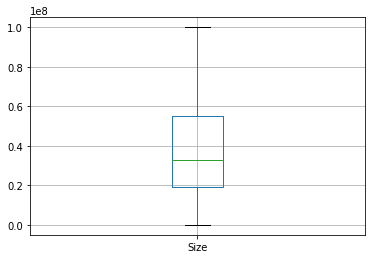

In [26]:
print(df_size_re.boxplot())

In [27]:
# Find the average of the Size
size_mean = df_size_re.mean()

# Find the median of the Size
size_median = df_size_re.median()

print(size_mean)
print(size_median)

Size    3.896798e+07
dtype: float64
Size    33000000.0
dtype: float64


In [28]:
# From the above exploration, we'll impute 'Varies with device' with the median of Size
df['Size']=df['Size'].str.replace('Varies with device', '33000000')
df['Size'].unique()

# Transform this column to numeric
df['Size']=pd.to_numeric(df['Size'], errors='coerce')

# Check
df['Size'].head()

0    19000000
1    14000000
2    87000000
3    25000000
4    28000000
Name: Size, dtype: int64

## Data Visualization

**Histogram**

We created histograms to observe the distribution. <br>
For the target variable, **Rating**, we see that the Rating distribution is left-skewed and the ratings are mostly concentrated in the range of 3.5 to 4.75. The mean of the Rating column is 4.2. For Size, one size has a distinctly high number of it is the result of our imputation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdab3218750>,
      dtype=object)

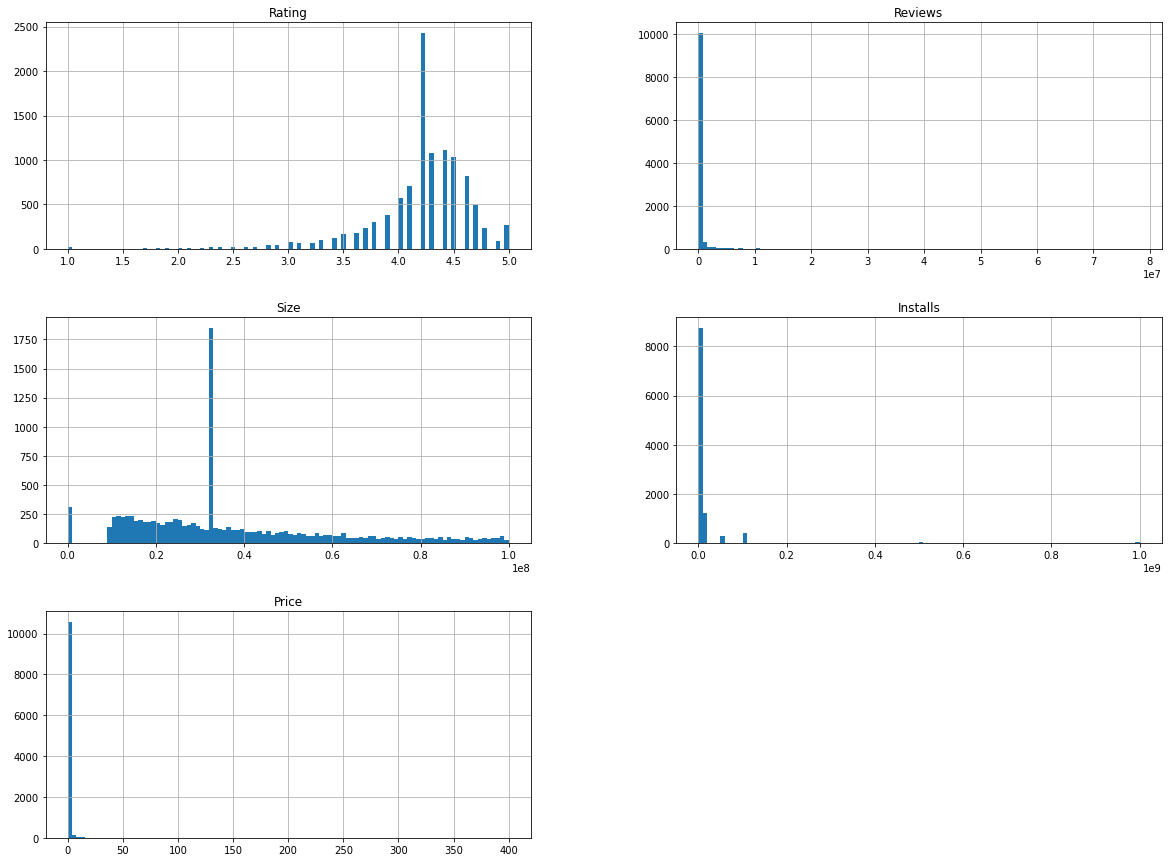

In [29]:
df.hist(bins=100,figsize=(20,15))

**Number of Apps in each category**

In this dataset, how many Apps in each category?

In [30]:
# Count the number of Apps in each group
num_app = df.groupby('Category')['App'].count()
num_app

Category
ART_AND_DESIGN           65
AUTO_AND_VEHICLES        85
BEAUTY                   53
BOOKS_AND_REFERENCE     231
BUSINESS                460
COMICS                   60
COMMUNICATION           387
DATING                  234
EDUCATION               156
ENTERTAINMENT           149
EVENTS                   64
FAMILY                 1972
FINANCE                 366
FOOD_AND_DRINK          127
GAME                   1144
HEALTH_AND_FITNESS      341
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
LIFESTYLE               382
MAPS_AND_NAVIGATION     137
MEDICAL                 463
NEWS_AND_MAGAZINES      283
PARENTING                60
PERSONALIZATION         392
PHOTOGRAPHY             335
PRODUCTIVITY            424
SHOPPING                260
SOCIAL                  295
SPORTS                  384
TOOLS                   843
TRAVEL_AND_LOCAL        258
VIDEO_PLAYERS           175
WEATHER                  82
Name: App, dtype: int64

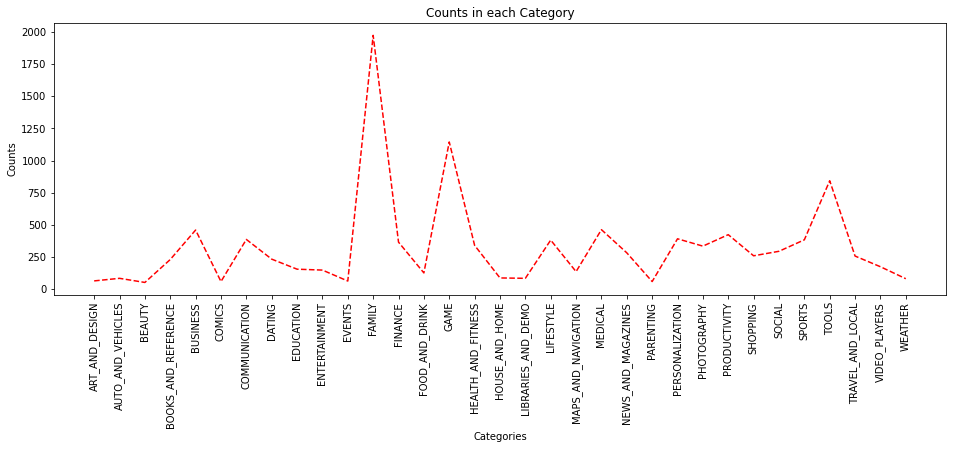

In [31]:
# Visualize the result
plt.figure(figsize=(16,5))
plt.plot(num_app, 'r--')
plt.xticks(rotation=90)
plt.title('Counts in each Category')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

Surprising, Family content the highest numbers of Apps in this dataset followed by Game, while the number of Communication Apps is not as large as we originally thought.

**The Percentage of overall Free vs Paid Apps**

We were also able to find the number of records in the free and paid app categories. There are 10,040 records in the Free catogory vs just 800 records in the Paid category. 
The Pie Chart below also gives us the visual representation of the Free vs Paid records. 92.6% are in the Free category and the rest 7.4% are in the Paid category. 

In [32]:
# How many records are free and paid apps?

# The value of one record is 0 instaed of Free so we modify it. 
df[df['Type'].isin([0])]
df['Type'][9148] = 'Free'
df['Type'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Free    10040
Paid      800
Name: Type, dtype: int64

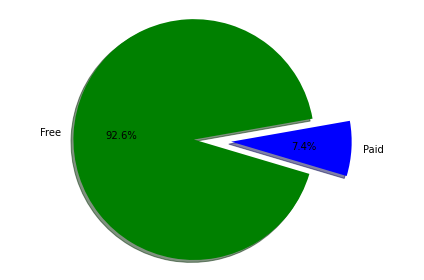

In [33]:
# Whate are the percentage of free and paid app on the Google App Store?
# Create a pie chart to visualize the data
# We can see 93.6% of the apps are free of charge

labels = ['Free','Paid']
explode=[0.01,0.3] 
colors = ['green', 'blue']
fig1, ax1 = plt.subplots()
ax1.pie(df['Type'].value_counts(), labels = labels, colors=colors, explode=explode, autopct='%1.1f%%',
        shadow=True,  startangle=10)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

**The Rating of Free and Paid Apps**

In the bar chart below, we grouped the data by Type and it outputs the average rating for Free and Paid apps are very similar with Paid apps having slightly higher average ratings of 4.253 compared to 4.188 for Free apps. However, we need to keep in mind that there is a huge difference in the number of records in each category, as shown in the pie chart earlier, before making any analysis or conclusions.

Type
Free    4.188018
Paid    4.253875
Name: Rating, dtype: float64


Text(0, 0.5, 'Rating')

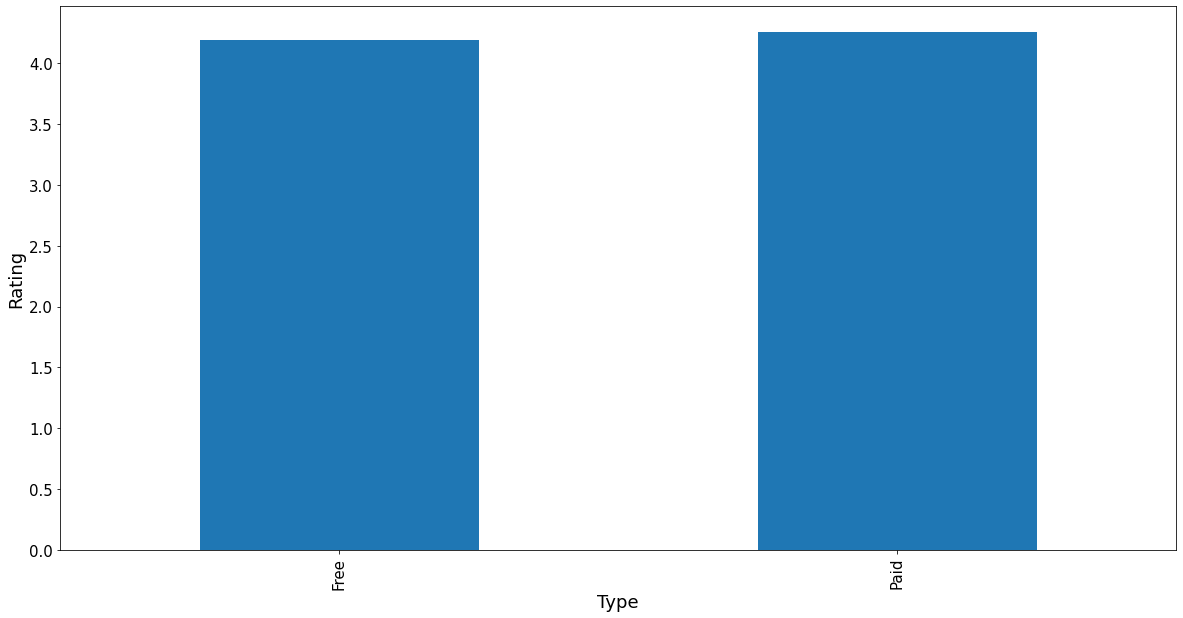

In [34]:
# What are the ratings of Free vs Paid apps?
# If free apps receive higher rating on average?
# We group the dataset by Type, but find that the average rating between two Free and Paid apps is close.

type_rating = df.groupby('Type')['Rating'].mean()
print(type_rating )
type_rating.plot(kind='bar',figsize=(20, 10), legend=False)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("Type", fontsize = 18)
plt.ylabel("Rating", fontsize = 18)

**Top 20 Most Installed Apps**

Here are the top 20 most installed apps. However since the dataset does not provide the exact number of installations, we see that all top 20 apps have 1,000,000,000+ installations. There are 59 apps in the dataset with 1 billion plus installations.

Text(0.5, 1.0, 'Top 20 Installed App in Google Play Store')

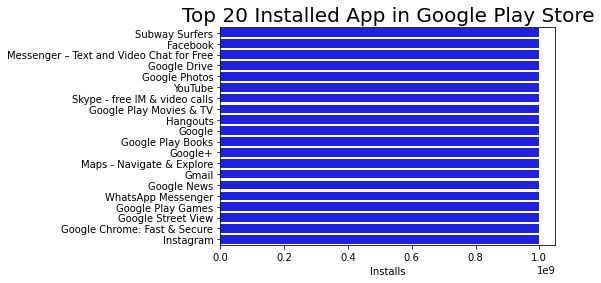

In [35]:
# What apps have the biggest numbers of installs?

popular = df.sort_values(['Installs'],ascending = 0 )[:58]
ax = sns.barplot(x = 'Installs' , y = 'App' , data = popular, color='blue')
ax.set_xlabel('Installs')
ax.set_ylabel('')
ax.set_title("Top 20 Installed App in Google Play Store", size = 20)

**Correlation among numerical variables**

For the numerical variables, we wanted to understand the correlations among them so that it can help us decide what variables to use as our predictors. 

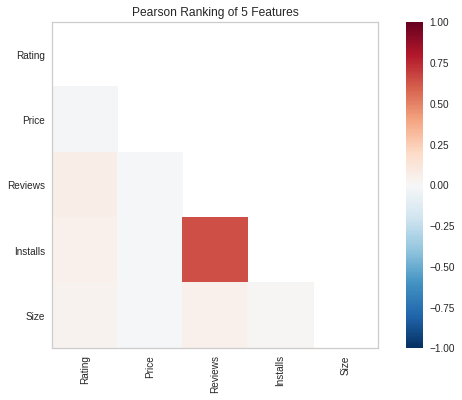

In [36]:
# To see if the numerical variables correlated
# and helpful or not to our model, we created Pearson Ranking visualization.

'''We find installs and reviews have the strongest corrleation and it's reasonable
  because the more installs means the app is more popular 
  and the popular app tend to have more people talk about it or write reviews.'''

# import the package for visualization of the correlation
from yellowbrick.features import Rank2D

# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

# extract the numpy arrays from the data frame
features = ['Rating', 'Price', 'Reviews', 'Installs', 'Size']
w = df[features].to_numpy()

# instantiate the 2D visualizer with the Pearson ranking algorithm
visualizer = Rank2D(features=features, algorithm='pearson')
visualizer.fit(w)             # Fit the data to the visualizer
visualizer.transform(w)       # Transform the data
visualizer.poof()             # Finalize and show the figure

We noticed that Reviews and Installs have the strongest correlations and that Reviews, Installs, and Sizes have correlations with Rating. As our goal is to predict Ratings, our team decided to use the numerical variables as our predictors.

**Let's check the Rating in each category**

Group the data by category and see how each category performs under different features.

In [37]:
grp = df.groupby('Category')
x = grp['Rating'].agg(np.mean)
y = grp['Price'].agg(np.mean)
z = grp['Reviews'].agg(np.mean)
l = grp['Reviews'].agg(np.sum)
u = grp['Installs'].agg(np.sum)
p = grp['Size'].agg(np.mean)
print(x)
print(y)
print(z)
print(u)
print(p)

Category
ART_AND_DESIGN         4.350769
AUTO_AND_VEHICLES      4.191765
BEAUTY                 4.262264
BOOKS_AND_REFERENCE    4.312554
BUSINESS               4.148261
COMICS                 4.156667
COMMUNICATION          4.164858
DATING                 4.008974
EDUCATION              4.387821
ENTERTAINMENT          4.126174
EVENTS                 4.365625
FAMILY                 4.193154
FINANCE                4.139891
FOOD_AND_DRINK         4.171654
GAME                   4.282780
HEALTH_AND_FITNESS     4.267155
HOUSE_AND_HOME         4.197727
LIBRARIES_AND_DEMO     4.183529
LIFESTYLE              4.113613
MAPS_AND_NAVIGATION    4.065693
MEDICAL                4.191793
NEWS_AND_MAGAZINES     4.144170
PARENTING              4.283333
PERSONALIZATION        4.308929
PHOTOGRAPHY            4.192537
PRODUCTIVITY           4.209434
SHOPPING               4.254615
SOCIAL                 4.248814
SPORTS                 4.219531
TOOLS                  4.067141
TRAVEL_AND_LOCAL       4.120543

**Category-wise Rating**

Categories of apps are plotted against their average ratings to see which categories have the highest average ratings. Surprisely, we find that Education, Events categories have the two highest average Rating, while Dating, Maps_and_Navigation, Tools, Video Player apps have the least average ratings.

Comparing this result with the number of Apps in Google Play Store, we assume that there are not many competitors in Education and Events categories and the users may not hold too much high standard when rating. Or as Installs of Education and Events are among the lowest, it is possible that these small groups of users who really need those Apps generally feel satisfied as long as the Apps are functional and helpful. 

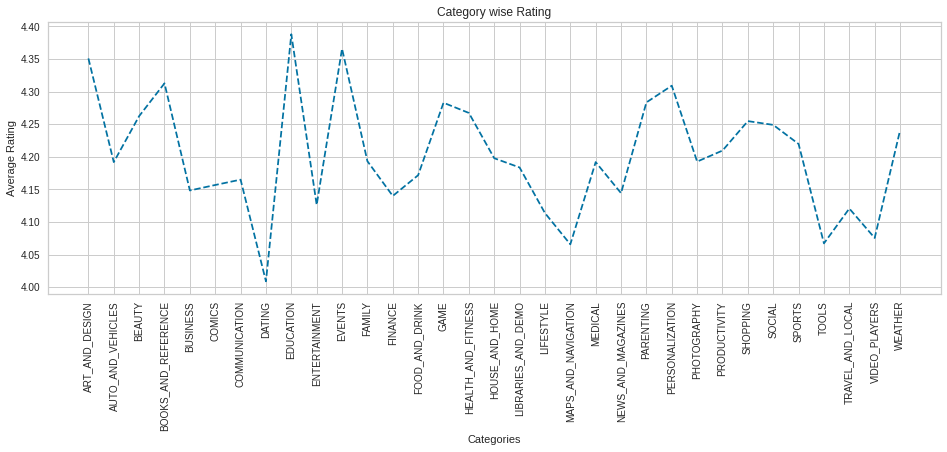

In [38]:
# What we observe from the categories?
'''Category wise rating,
Education category has the highest average rating scores.'''

plt.figure(figsize=(16,5))
plt.plot(x, 'b--')
plt.xticks(rotation=90)
plt.title('Category wise Rating')
plt.xlabel('Categories')
plt.ylabel('Average Rating')
plt.show()

**Category-wise Prices**

Categories of apps are plotted against their Prices. We find that Finance, Lifestyle apps have highest average price. However, only around 7.4% of the apps are Paid apps in this dataset.


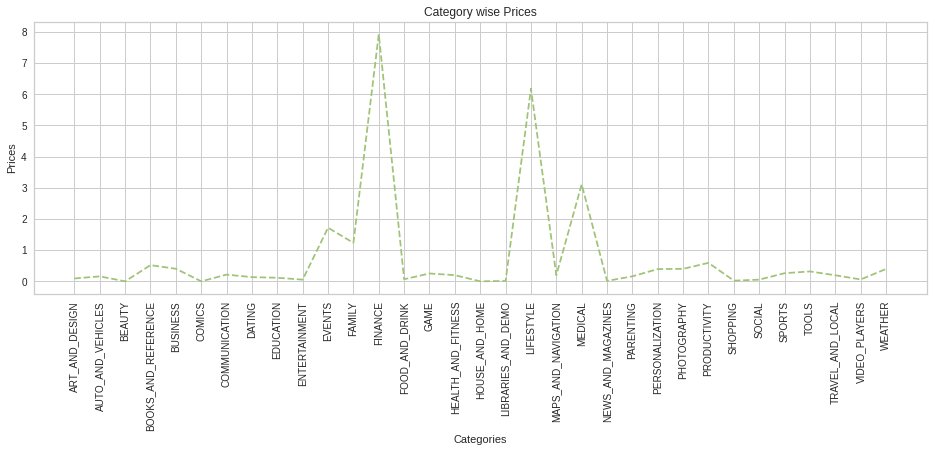

In [39]:
'''Category wise prices,
Finance Apps on average cost more to download.'''

plt.figure(figsize=(16,5))
plt.plot(y, 'g--')
plt.xticks(rotation=90)
plt.title('Category wise Prices')
plt.xlabel('Categories')
plt.ylabel('Prices')
plt.show()

**Category-wise Average Reviews**

Categories of apps are plotted against Average Reviews. We can see that Communicaton, Social and Game apps have the top 3 average number of reviews respectively. 

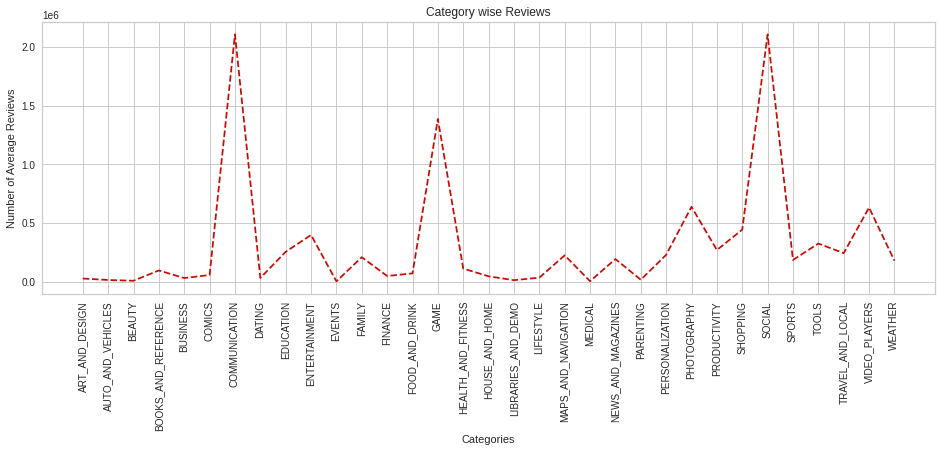

In [40]:
'''Category wise reviews,
both Communication and Social category have the highest average review scores.'''

plt.figure(figsize=(16,5))
plt.plot(z, 'r--')
plt.xticks(rotation=90)
plt.title('Category wise Reviews')
plt.xlabel('Categories')
plt.ylabel('Number of Average Reviews')
plt.show()

**Category-wise Sum of Reviews**

Which category has received the highest amount of reviews?



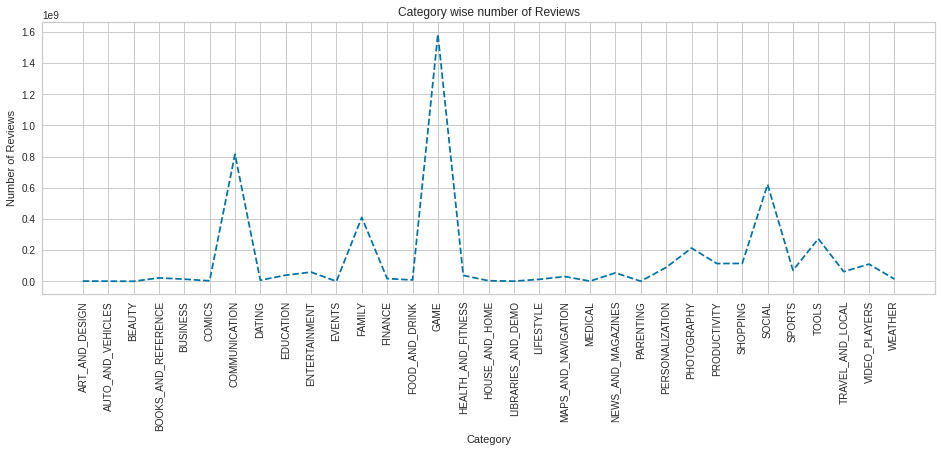

In [41]:
'''Category wise sum of Rating,
Game received the highest number of reviews. Wow, gamers love to provide feedback!'''

plt.figure(figsize=(16,5))
plt.plot(l, 'b--')
plt.xticks(rotation=90)
plt.title('Category wise number of Reviews')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.show()

**Category-wise Average Size**

Categories of apps are plotted against Average Size. We find that Game and Family apps have the highest average size. 

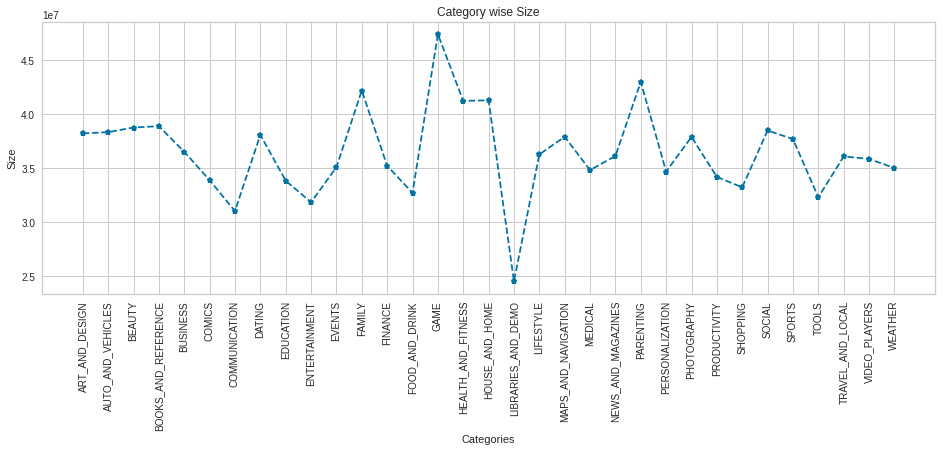

In [42]:
'''Category wise size,
Game category has the highest average Size scores. Not so surprise, it always take longer time to download the Game Apps!'''

plt.figure(figsize=(16,5))
plt.plot(p, 'p--')
plt.xticks(rotation=90)
plt.title('Category wise Size')
plt.xlabel('Categories')
plt.ylabel('Size')
plt.show()

**Installs-wise Rating**

We tried to find if the number of installation will influence the Rating of an App.

In [43]:
# Groupby Install
# Taking rating as the independent variable
grp = df.groupby('Installs')
k = grp['Rating'].agg(np.mean)
m = df['Installs']
print(k)

Installs
0             4.200000
1             4.235821
5             4.245122
10            4.275907
50            4.260000
100           4.270236
500           4.185758
1000          4.095259
5000          4.041090
10000         4.046395
50000         4.054906
100000        4.111719
500000        4.168275
1000000       4.220836
5000000       4.243218
10000000      4.313419
50000000      4.351211
100000000     4.411491
500000000     4.350000
1000000000    4.258621
Name: Rating, dtype: float64


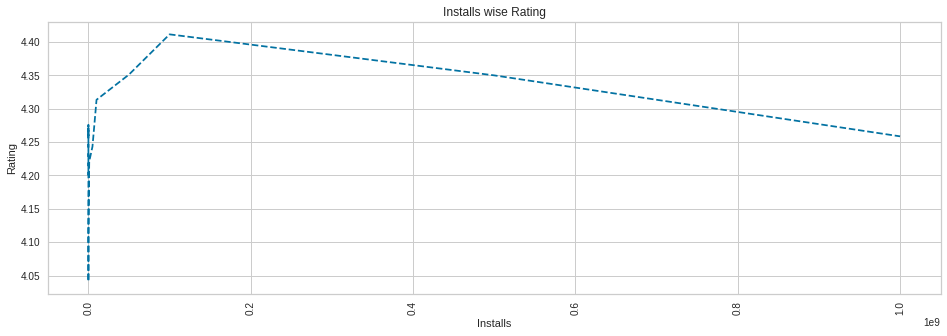

In [44]:
# Relation between rating and installations

#Plotting Installs versus Rating
plt.figure(figsize=(16,5))
plt.plot(k, 'b--')
plt.xticks(rotation=90)
plt.title('Installs wise Rating')
plt.xlabel('Installs')
plt.ylabel('Rating')
plt.show()

**Most Installed Catoegory**

Categories of apps are plotted against Average Installs. From the graph we identify Game and Communication apps have the most installations. This graph looks quite similar to the previous graph showing average number of reviews per categories. This is expected due to the correlation between the Installs and Reviews columns. 

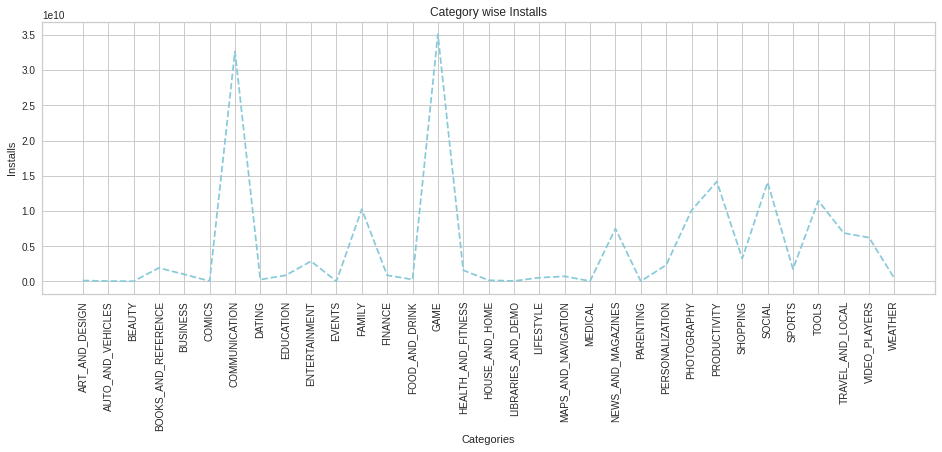

In [45]:
'''Category wise installs,
Game has the highest average installs, followed by Communication Apps'''

plt.figure(figsize=(16,5))
plt.plot(u, 'c--')
plt.xticks(rotation=90)
plt.title('Category wise Installs')
plt.xlabel('Categories')
plt.ylabel('Installs')
plt.show()

# 3. Modeling

## Model Development & Result

In this project the target variable is numeric and it is to predict ratings of the apps on google store so we implemented models accordingly and they are KNN, Random Forest, Neural Networks, and Decision Tree.

**Pre Models Prototype: Linear Regression Model**

In [46]:
#Creating the linear regression model

#Defining rating variable as dependent variable
y=df.Rating

#Defining installs as an independent variable
X=sm.add_constant(df.Installs)

#Model definition
model=sm.OLS(y,X)

#Model fit
results=model.fit()

#Get the summary of results
results.summary()

# Concating predictors and target variables
R=pd.concat([y,X],axis=1)

# Predicting the results
predictions = results.predict()

# Converting to series
predictions = pd.Series(predictions)

# Concating with exisitng dataset
R= pd.concat([predictions,R],axis=1)

#Changed the column name to predicted rating
R.columns.values[0]= 'Predicted_Rating'

#Find the residuals
res=results.resid

#Concatinating residual with the existing dataset
R = pd.concat([res,R],axis=1)

#Changing the column name to residuals
R.columns.values[0]= 'Residuals'
R.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Residuals,Predicted_Rating,Rating,const,Installs
0,-0.088457,4.188457,4.1,1.0,10000.0
1,-0.288597,4.188597,3.9,1.0,500000.0
2,0.510116,4.189884,4.7,1.0,5000000.0
3,0.297241,4.202759,4.5,1.0,50000000.0
4,0.111517,4.188483,4.3,1.0,100000.0


**Model Creation**

In [47]:
# Define independent and dependent variables
y = df.Rating
X = df[['Installs','Price','Size','Reviews']]

# Partition the data into training and testing
from sklearn.model_selection import train_test_split                # I mentioned this at the beginning, but write again for reference.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

**KNN** <br>
K Nearest Neighbour can be used both for classification and prediction purposes. We used this model for prediction of ratings of the android apps. The independent variables are number of installations, price of the app, size of the app and number of reviews. All are numeric variables.

In [48]:
#Building the KNN Model on our dataset
KNN_model = KNeighborsRegressor(n_neighbors=3).fit(X_train,y_train)

y_pred1 = KNN_model.predict(X_test) #Predictions on Testing data
(y_pred1)

#Find Root mean squared error (RMSE)
import sklearn.metrics as metrics
print('Root Mean Squared Error: %.2f'% np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))
print('R Squared Score is: %.2f'%  r2_score(y_test, y_pred1))
print('Mean Absolute Error: %.2f'% metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error: %.2f'%  metrics.mean_squared_error(y_test, y_pred1))

Root Mean Squared Error: 0.53
R Squared Score is: -0.24
Mean Absolute Error: 0.35
Mean Squared Error: 0.28


The possible reason for the model’s unsatisfactory performance can be these of models are not well-suited for predicting continuous variables

**Neural Network**

Neural network is an algorithm that identifies the relationship in a set of data through a process that is similar to functioning of the human brain. It is made of processing units that consists of inputs and outputs. The neural network learns from the input and produces the output.


In [49]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#mlp = MLPRegressor(hidden_layer_sizes=(4,4,4),max_iter=250)
#mlp.fit(X_train,y_train)
#predictions = mlp.predict(X_test)

mlp = MLPRegressor(hidden_layer_sizes=(9,9),max_iter=500)
mlp.fit(X_train,y_train)

y_pred3 = mlp.predict(X_test)

print('R Squared Score is:%.2f'% r2_score(y_test, y_pred3))
print('Mean Absolute Error:%.2f'%metrics.mean_absolute_error(y_test, y_pred3))
print('Mean Squared Error:%.2f'% metrics.mean_squared_error(y_test, y_pred3))
print('Mean Squared Error:%.2f'% np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))

R Squared Score is:0.03
Mean Absolute Error:0.31
Mean Squared Error:0.22
Mean Squared Error:0.47


**Decision Tree** <br>
Decision Tree model is basically a ML algorithm that partitions the data into subsets. The partitioning process starts with a binary split. It continues until no further splits can be made. Various branches of variable length are formed in this model.

In [50]:
# There are two kinds of Decision trees and because our target variable is numeric,
# we use DecisionTreeRegressor for this dataset

# Partition data

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Take a look at their shape and make sure the shapes match

print("For features - # of samples in training set: ", X_train.shape)
print("For targets -  # of samples in training set: ", y_train.shape)
print("For features - # of samples in test set:     ", X_test.shape)
print("For targets -  # of samples in test set:     ", y_test.shape)

# Fit the decision treee with x and y data using DecisionTreeRegressor

model_tree3 = DecisionTreeRegressor(criterion = 'mse', max_depth=6)
model_tree3.fit(X_train, y_train)

# Visualize the result

from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(model_tree3, class_names=sorted(y.unique()), filled=True)
graphviz.Source(dot_data)

# Build a predictive model using testing dataset

y_pred4 = model_tree3.predict(X_test)

# Exame the error score of the prediction

print("                          ")
print('*********Results**********')
print("                          ")
print('R Squared Score is:%.2f'% r2_score(y_test, y_pred4))
print('Mean Absolute Error:%.2f'% metrics.mean_absolute_error(y_test, y_pred4))
print('Mean Squared Error:%.2f'% metrics.mean_squared_error(y_test, y_pred4))
print('Root Mean Squared Error:%.2f'% np.sqrt(metrics.mean_squared_error(y_test, y_pred4)))

For features - # of samples in training set:  (8130, 4)
For targets -  # of samples in training set:  (8130,)
For features - # of samples in test set:      (2710, 4)
For targets -  # of samples in test set:      (2710,)
                          
*********Results**********
                          
R Squared Score is:0.07
Mean Absolute Error:0.30
Mean Squared Error:0.20
Root Mean Squared Error:0.45


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The possible reason for the model’s unsatisfactory performance can be these types of models are not well-suited for predicting continuous variables.

**Random Forest**

A random forest is a supervised machine learning algorithm that is constructed from decision tree algorithms. The fundamental concept behind random forest is a simple but powerful one — the wisdom of crowds. In data science speak, the reason that the random forest model works so well is: A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.

In [51]:
#Partition data 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

random_forest = RandomForestRegressor(n_estimators=100,random_state=0)

random_forest.fit(X_train, y_train)

y_pred2 = random_forest.predict(X_test)

random_forest.score(X_train, y_train)

# fit the regressor with x and y data
random_forest.fit(X, y)

y_pred2 = random_forest.predict(X_test)  # test the output by changing values

print('Mean Absolute Error: %.2f'% metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error: %.2f'% metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error: %.2f'% np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('R Squared Score is: %.2f'% r2_score(y_test, y_pred2))


# Random forest was chosen to be the best fit as it has highest R square value. 

# Convert predicted values into a series
y_pred2 = pd.Series(y_pred2)

# Concate y_pred2 with all other numerical variables
temp1 = pd.concat([df[['App','Category','Type','Installs']],y_pred2],axis=1)
temp1.columns.values[4] = 'Predicted_Ratings'

Mean Absolute Error: 0.12
Mean Squared Error: 0.04
Root Mean Squared Error: 0.20
R Squared Score is: 0.82


In [52]:
#Create a new csv file containing predicted ratings and all numerical variables ()
temp1.to_csv('Predictedgoogle_data.csv',index=False)

df = pd.read_csv('Predictedgoogle_data.csv')

Here we can say that random forest model performed better than decision tree model because it is a mean of individual tree.

## Model Selection

Compare the error results from the above models, we decided to go with Random Forest as it has the lowest error values. And here are some plots we made to visualize our Predicted Ratings on each features.

**Plot 1 : Predicted Ratings vs Installs**

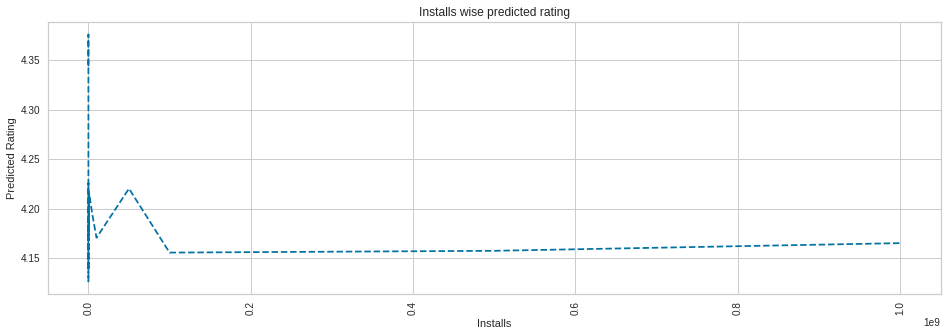

In [59]:
# How does rating influence the app installations?

# Group by installs
grp = df.groupby('Installs')

# Find the mean of ratings for each group
a = grp['Predicted_Ratings'].agg(np.mean)
a.head()

# Plot shows the graph of Predicted ratings Vs Installs
plt.figure(figsize=(16,5))
plt.plot(a, 'b--')
plt.xticks(rotation=90)
plt.title('Installs wise predicted rating')
plt.xlabel('Installs')
plt.ylabel('Predicted Rating')
plt.show()

**Plot 2 : Predicted Ratings vs Type**

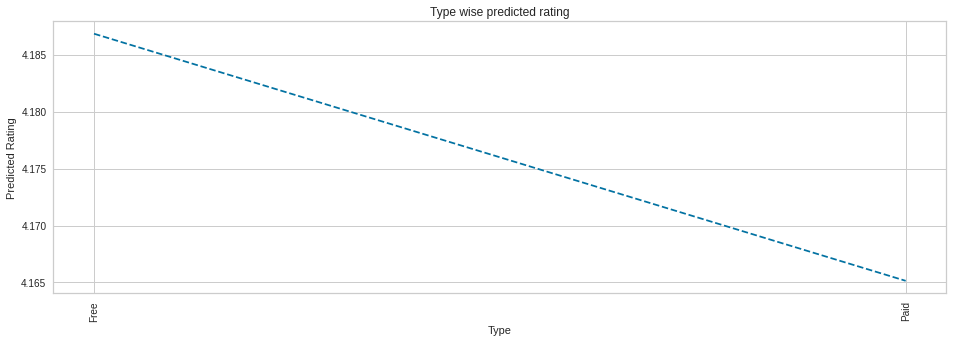

In [60]:
# What are the ratings of free Vs paid apps?

# Group by 'Type'
grp2 = df.groupby('Type')

# Find the mean of predicted ratings for each group
t = grp2.Predicted_Ratings.agg(np.mean)

# Plot shows the graph of Predicted ratings Vs Type of app
plt.figure(figsize=(16,5))
plt.plot(t, 'b--')
plt.xticks(rotation=90)
plt.title('Type wise predicted rating')
plt.xlabel('Type')
plt.ylabel('Predicted Rating')
plt.show()

# Graph shows that free apps have slightly higher ratings than paid apps, 
# but take a closer look will see the differences is trivial, and thus we don't consider this feature a crucial one.

**Plot 3 : Predicted Ratings vs Category**


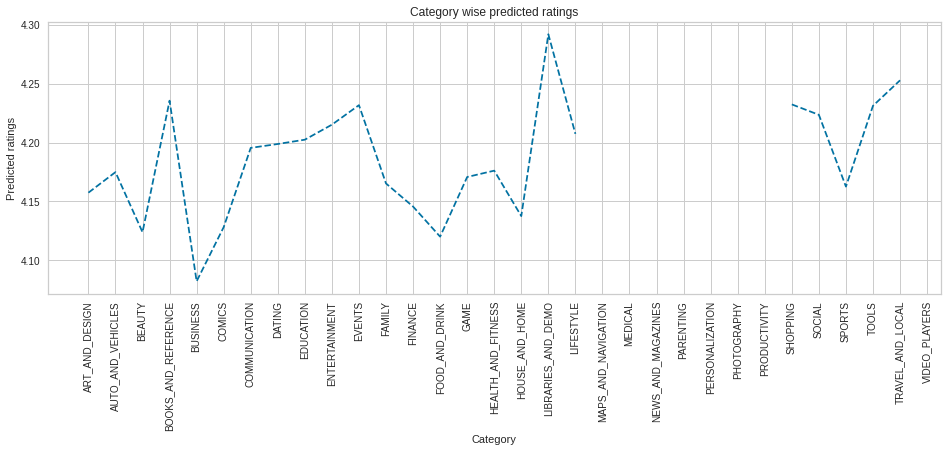

In [61]:
# What is the mean of rating for each category of app?

# Group by category
grp5 = df.groupby('Category')

# Find the mean of ratings for each group
o = grp5.Predicted_Ratings.agg(np.mean)

# Plot shows the graph of Category Vs Predicted_ratings
plt.figure(figsize=(16,5))
plt.plot(o, 'b--')
plt.xticks(rotation=90)
plt.title('Category wise predicted ratings')
plt.xlabel('Category')
plt.ylabel('Predicted ratings')
plt.show()

#Libraries and demo are likely to have high predicted ratings



#4. Conclusion

**Random Forest Model has the best predictive ability**<br>
The Google Play Store has enormous potential to drive the android app-making business. Our project involves the application of various machine learning algorithms on the Google Play Store dataset. Our analysis reveals that the Random Forest Model is better in terms of prediction as it has high R squares values (0.82), low Mean Absolute Error(0.12), Mean Squared Error(0.04), and Root Mean Squared Error(0.19).

**Launch Communication Apps**<br>

Our observation about this dataset is close to our daily lives where Game and Communication have the highest installs among all the categories. The top 20 most installed Apps mainly fall into these two categories. We can develop Apps in these categories, but as the number of Communication Apps available on the Google Play Store is smaller than Game, I would suggest launching Communication Apps as the competitors are lesser and then more likely to be installed and get popularity if it is a good App.

**Free/Paid difference does not influence Apps' Rating**<br>

Launching the App free or with charge doesn't influence the Rating that much. In business, we normally want to get more popularity by launching free Apps. But I assume if people want or need those Apps, they are willing to pay and if those Apps are really good, they give them a high Rating.

**Reference**

(1) Mobile operating systems' market share worldwide from January 2012 to June 2021, Statista, https://www-statista-com.ezproxy.lib.uconn.edu/statistics/272698/global-market-share-held-by-mobile-operating-systems-since-2009/


(2) Analysis of Google Play Store Dataset and Predict the popularity of an app on Google Play Store, Rimsha Maredia, Texas A&M University.


(3) Google Play Store Apps, Kaggle, https://www.kaggle.com/lava18/google-play-store-apps

#5. Project Credit

Team 04 OPIM-5512-Data Science using Python <br>
**Predicting ratings of Google Play Store Apps** <br>

Ashima Gupta <br>
Kiran Kumar Rallabandi <br>
Shanmukhi L <br>
Shakeel Saleem <br>
Ting-Yun Cheng<br>

Thanks my team members, it's an interesting project and I had lots of fun working with them.